## Directory and Structure
```
|-- evaluate.ipynb
|-- train.ipynb
|-- backbone.pth.tar               # VGG16 backbone pretrained on SHT Part_A
|-- ShanghaiTech
    |-- part_A
        |-- test_data 
            |-- images             # Contain the testing images
            |-- images-pt          # Contain the features of training images in .pt format (Auto generated)
            |-- ground-truth       # Contain the ground-truth of training images in .mat format
            |-- ground-truth-csv   # Contain the ground-truth of testing images in .csv format (Auto generated)
        |-- train_data    
            |-- images             # Contain the training images
            |-- images-pt          # Contain the features of training images in .pt format (Auto generated)
            |-- ground-truth       # Contain the ground-truth of training images in .mat format
            |-- ground-truth-csv   # Contain the ground-truth of training images in .csv format (Auto generated)
            
    |-- part_B
        |-- test_data
            |-- images
            |-- ground-truth
        |-- train_data
            |-- images
            |-- ground-truth
|-- Models                         # Contain the trained models
|-- Results                        # Contain the logs of the training

```

## Load all the require library and settings

In [1]:
import torch
import numpy as np
import time
import cv2
import shutil
import pandas as pd
import scipy.io as sio
from scipy.io import loadmat
import os
from torchvision import transforms
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision.models import vgg16

from model import *
from utility import *

device            = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
USE_PYTORCH_VGG16 = False

print("Device Used:",device)
print("Use Pre-trained VGG-16 from","pytorch" if USE_PYTORCH_VGG16 else "Journal 'Counting Objects by Blockwise Classification' ")

Device Used: cuda
Use Pre-trained VGG-16 from Journal 'Counting Objects by Blockwise Classification' 


In [2]:
# The dataset is download from kaggle https://www.kaggle.com/datasets/tthien/shanghaitech/data
part_A_dir    = "ShanghaiTech/part_A/"
part_B_dir    = "ShanghaiTech/part_B/"

# Select the dataset used
dataset_used  = "Part A"
if dataset_used == "Part A":
    dataset_dir = part_A_dir
elif dataset_used == "Part B":
    dataset_dir = part_B_dir

In [3]:
# Get the directory to each of the files
train_img_dir = "train_data/images/"
train_gt_dir  = "train_data/ground-truth/"
train_img_pt  = "train_data/images-pt/"
train_gt_csv  = "train_data/ground-truth-csv/"

test_img_dir  = "test_data/images/"
test_gt_dir   = "test_data/ground-truth/"
test_img_pt   = "test_data/images-pt/"
test_gt_csv   = "test_data/ground-truth-csv/"

# Contain list of path that directly point to the file 
train_img_dir_list = [dataset_dir + train_img_dir + filename for filename in sorted(os.listdir(dataset_dir + train_img_dir)) if filename.endswith(".jpg")]
train_gt_dir_list  = [dataset_dir + train_gt_dir  + filename for filename in sorted(os.listdir(dataset_dir + train_gt_dir)) if filename.endswith(".mat")]

test_img_dir_list  = [dataset_dir + test_img_dir + filename for filename in sorted(os.listdir(dataset_dir + test_img_dir)) if filename.endswith(".jpg")]
test_gt_dir_list   = [dataset_dir + test_gt_dir  + filename for filename in sorted(os.listdir(dataset_dir + test_gt_dir)) if filename.endswith(".mat")]

test_img_pt_list  = [dataset_dir + test_img_pt  + filename for filename in sorted(os.listdir(dataset_dir + test_img_pt)) if filename.endswith(".pt")]
test_gt_csv_list  = [dataset_dir + test_gt_csv  + filename for filename in sorted(os.listdir(dataset_dir + test_gt_csv)) if filename.endswith(".csv")]


print("Number of training data:",len(train_gt_dir_list))
print("Number of testing  data:",len(test_gt_dir_list))

Number of training data: 300
Number of testing  data: 182


## Analyze the result

['QL_opt', 'QL_N_opt', 'CE_opt', 'CE_N_opt', 'CB_opt', 'CB_N_opt']
Train list: [126.78888888888888, 115.5, 92.5111111111111, 69.9037037037037, 62.03333333333333, 83.2925925925926]
Valid list: [129.43333333333334, 107.5, 93.73333333333332, 74.2, 61.333333333333336, 78.23333333333333]


Text(0, 0.5, 'Validation MAE')

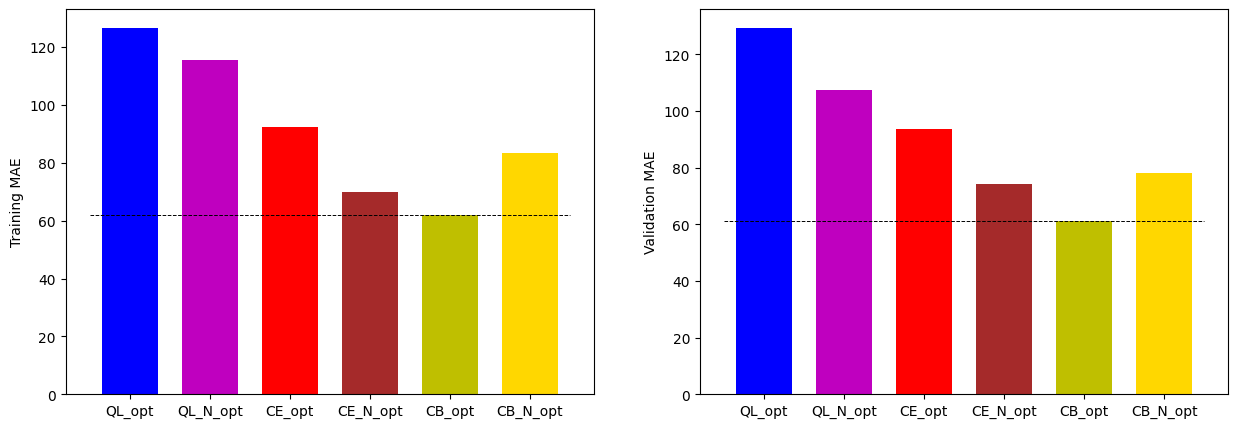

In [4]:
list_valid_mae   = []
list_train_mae   = []
list_method_used = []
color_list = ["b","m", "red","brown", "y","gold"]
VGG_name = "" if USE_PYTORCH_VGG16 else "_THF" # THF = Trained for obtaining human features

for LOSS_FUNCTION in ["QL", "CE", "CB"]: # For loss funciton in [Q learning loss, cross entropy loss, combine of Q learning loss and cross entropy]
    for TRAIN_WITH_OPTIMAL_ACTION in [True, False]:
        optimal_str = "opt" if TRAIN_WITH_OPTIMAL_ACTION else "N_opt"
        MODEL_DIR = f"Models{VGG_name}/Model_{LOSS_FUNCTION}_{optimal_str}"
        RESULT_DIR= f"Results{VGG_name}/Result_{LOSS_FUNCTION}_{optimal_str}"
        df = pd.read_csv(f"{RESULT_DIR}/results.csv")
        
        list_valid_mae.append(df["Valid mae"].min())
        list_train_mae.append(df["Train mae"].min())
        list_method_used.append(f"{LOSS_FUNCTION}_{optimal_str}")


print(list_method_used)
print("Train list:",list_train_mae)
print("Valid list:",list_valid_mae)


fig, ax = plt.subplots(1,2, figsize=(15,5))


x_axis  = np.arange(-0.5,6.5)

ax[0].plot(x_axis, [np.min(list_train_mae)] * len(x_axis), "--k", linewidth=0.7)
ax[0].bar(list_method_used, list_train_mae, color=color_list, width = 0.7)
ax[0].set_ylabel("Training MAE")

ax[1].plot(x_axis, [np.min(list_valid_mae)] * len(x_axis), "--k", linewidth=0.7)
ax[1].bar(list_method_used, list_valid_mae, color=color_list, width = 0.7)
ax[1].set_ylabel("Validation MAE")

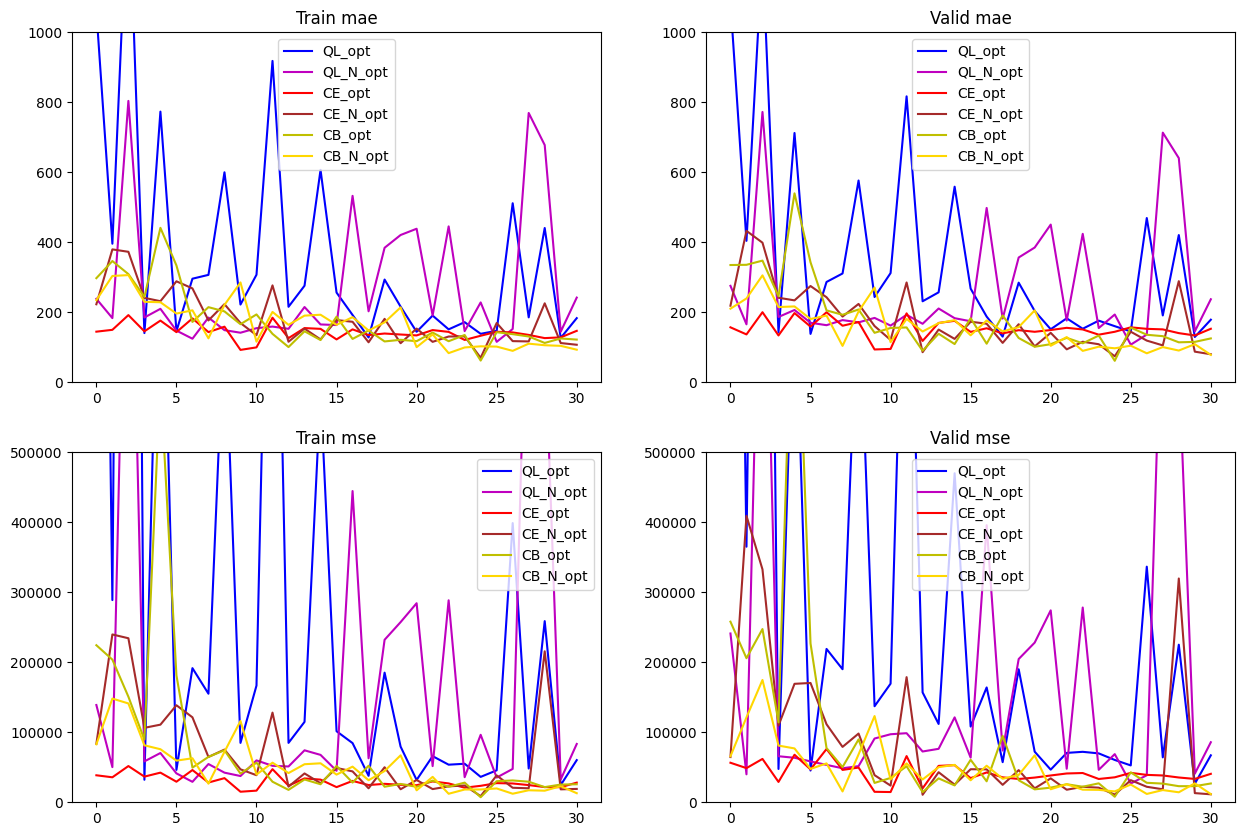

In [5]:
# Plot all the loss and evaluation metric for difference settings, Not that good in visualization
SKIP_FIRST = 0
fig, ax = plt.subplots(2,2, figsize=(15,10))

color_list = ["b","m", "red","brown", "y","gold"]
count      = 0
for LOSS_FUNCTION in ["QL","CE", "CB"]: # For loss funciton in [Q learning loss, cross entropy loss, combine of Q learning loss and cross entropy]
    for TRAIN_WITH_OPTIMAL_ACTION in [True, False]:
        color_used  = color_list[count]
        count      += 1
        optimal_str = "opt" if TRAIN_WITH_OPTIMAL_ACTION else "N_opt"
        MODEL_DIR   = f"Models{VGG_name}/Model_{LOSS_FUNCTION}_{optimal_str}"
        RESULT_DIR  = f"Results{VGG_name}/Result_{LOSS_FUNCTION}_{optimal_str}"
        df = pd.read_csv(f"{RESULT_DIR}/results.csv")
        
        for i, col in enumerate(["Train mae", "Valid mae", "Train mse", "Valid mse"]):  # "Train Loss"
            if col.endswith("mae"):
                ax[i//2][i%2].set_ylim(0,1000)
            elif col.endswith("mse"):
                ax[i//2][i%2].set_ylim(0, 5e5)
            title_name = f"{LOSS_FUNCTION}_{optimal_str}"
            ax[i//2][i%2].plot(df[col].to_numpy()[SKIP_FIRST:], color_used,label=title_name)
            ax[i//2][i%2].set_title(col)
            ax[i//2][i%2].legend()


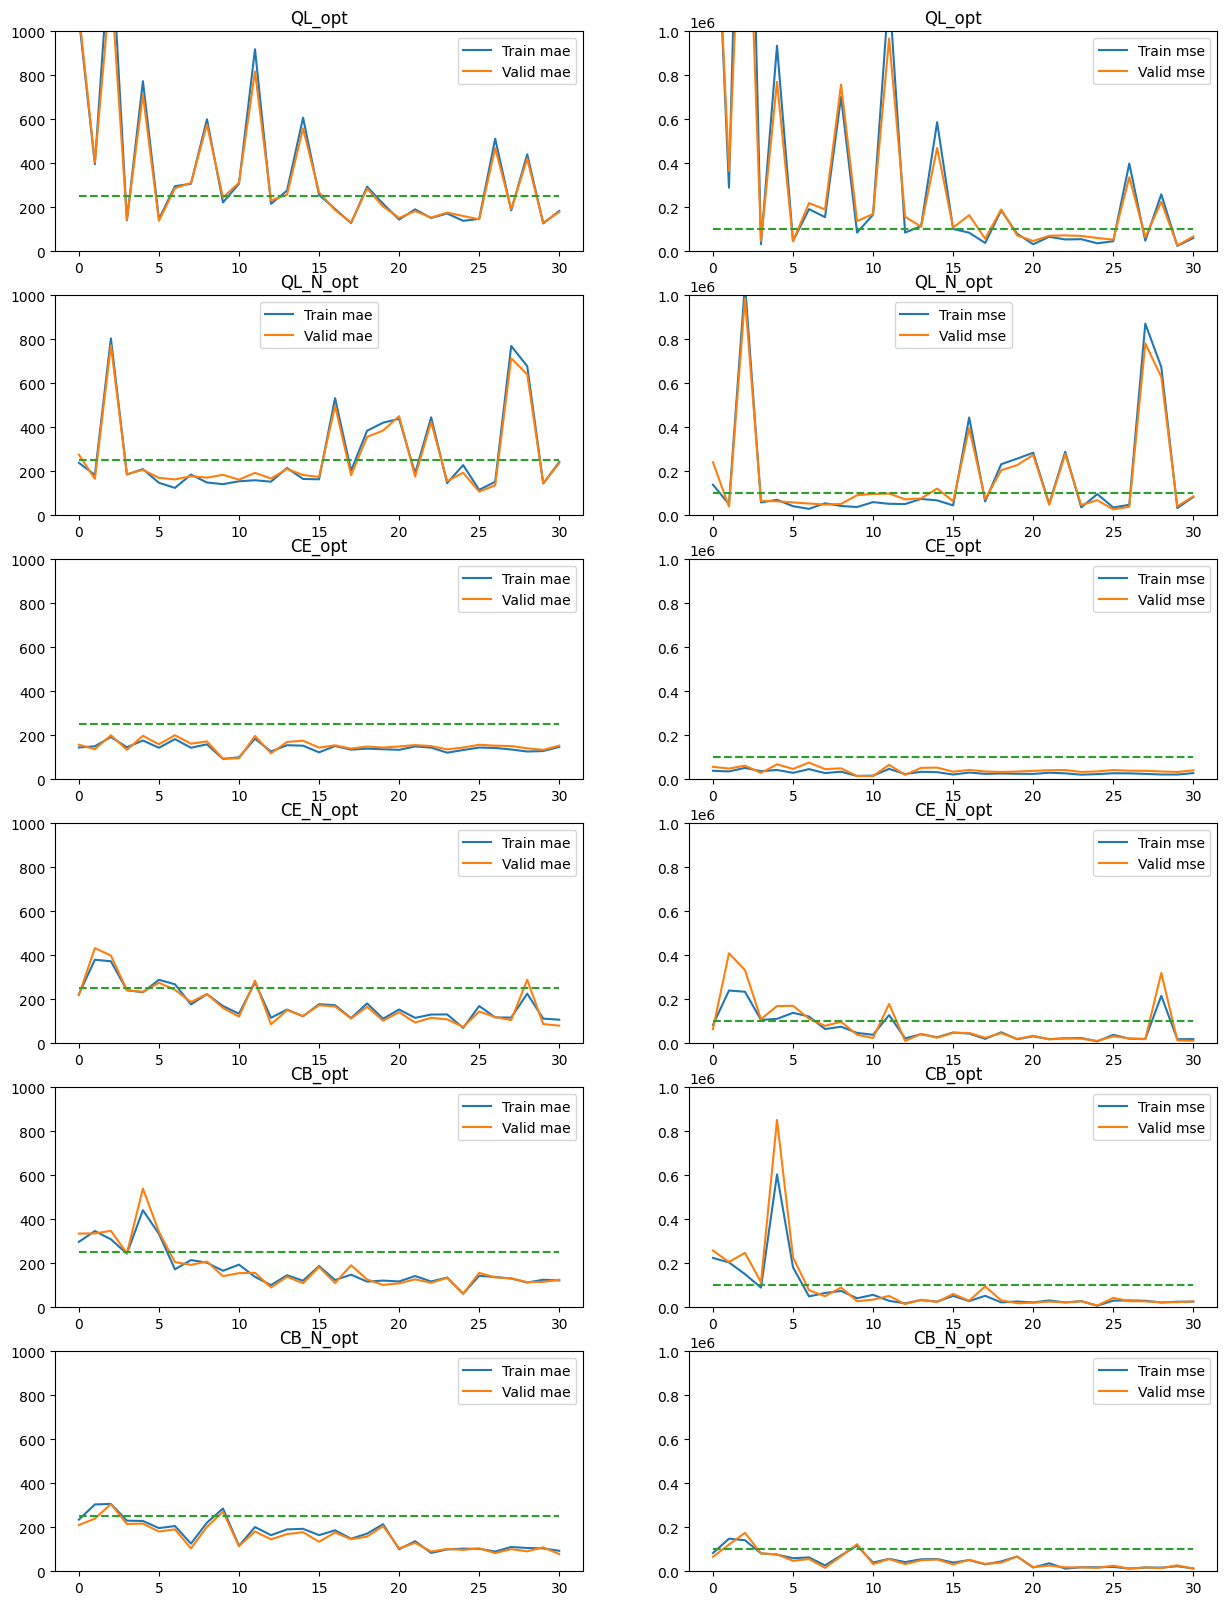

In [6]:
SKIP_FIRST = 0
fig, ax = plt.subplots(6,2, figsize=(15,20))

row = 0
for LOSS_FUNCTION in ["QL", "CE", "CB"]: # For loss funciton in [Q learning loss, cross entropy loss, combine of Q learning loss and cross entropy]
    for TRAIN_WITH_OPTIMAL_ACTION in [True, False]:
        optimal_str = "opt" if TRAIN_WITH_OPTIMAL_ACTION else "N_opt"
        MODEL_DIR = f"Models{VGG_name}/Model_{LOSS_FUNCTION}_{optimal_str}"
        RESULT_DIR= f"Results{VGG_name}/Result_{LOSS_FUNCTION}_{optimal_str}"
        df = pd.read_csv(f"{RESULT_DIR}/results.csv")
        title_name = f"{LOSS_FUNCTION}_{optimal_str}"
        
        x_length = len(df["Train mae"].to_numpy()[SKIP_FIRST:])
        ax[row][0].plot(df["Train mae"].to_numpy()[SKIP_FIRST:], label="Train mae")
        ax[row][0].plot(df["Valid mae"].to_numpy()[SKIP_FIRST:], label="Valid mae")
        ax[row][0].plot(range(x_length), [250] * x_length, "--")
        ax[row][0].set_ylim(0,1000)
        ax[row][0].legend()
        ax[row][0].set_title(title_name)
        
        ax[row][1].plot(df["Train mse"].to_numpy()[SKIP_FIRST:], label="Train mse")
        ax[row][1].plot(df["Valid mse"].to_numpy()[SKIP_FIRST:], label="Valid mse")
        ax[row][1].plot(range(x_length), [100000] * x_length, "--")
        ax[row][1].set_ylim(0,1e6)
        ax[row][1].legend()
        ax[row][1].set_title(title_name)
            
        row += 1

## Evaluate the model from test dataset

In [7]:
if USE_PYTORCH_VGG16:
    print("Loading model from pytorch...")
    vgg16_pretrained = vgg16(weights="VGG16_Weights.IMAGENET1K_V1").features.to(device)
else:
    vgg16_pretrained = VGG16_BackBone().to(device)
    if os.path.exists("backbone.pth.tar"):
        print("Loading model from backbone.pth.tar...")
        vgg16_pretrained.load_state_dict(torch.load('backbone.pth.tar')['state_dict'])
    else:
        del vgg16_pretrained
        raise("Pretrained VGG-16 (backbone.pth.tar) does not exists")

for param in vgg16_pretrained.parameters():
    param.requires_grad = False

print("Done")

Loading model from backbone.pth.tar...
Done


In [8]:
# Look on the shape of image
shape_count = {}
max_x       = 0
max_y       = 0

for img_filename in test_img_dir_list:
    img       = cv2.imread(img_filename)
    img_shape = img.shape 
    if img_shape not in shape_count:
        shape_count[img_shape] = 1
    else:
        shape_count[img_shape] += 1
        
    if img_shape[0] > max_x:
        max_x = img_shape[0]
    if img_shape[1] > max_y:
        max_y = img_shape[1]

print("Number of image        :", len(test_img_dir_list))
print("Number of unique shape :", len(shape_count))
print("Max x, y               :", max_x, max_y)
print(shape_count)

Number of image        : 182
Number of unique shape : 123
Max x, y               : 1024 1024
{(704, 1024, 3): 1, (768, 1024, 3): 16, (409, 902, 3): 1, (768, 962, 3): 1, (276, 460, 3): 3, (666, 1024, 3): 1, (683, 1024, 3): 23, (661, 1024, 3): 1, (476, 1001, 3): 1, (463, 691, 3): 1, (552, 1024, 3): 2, (684, 1024, 3): 4, (720, 960, 3): 1, (506, 1024, 3): 1, (611, 400, 3): 1, (396, 594, 3): 1, (600, 900, 3): 1, (676, 1024, 3): 3, (609, 469, 3): 1, (760, 1024, 3): 1, (448, 640, 3): 1, (659, 1024, 3): 1, (424, 636, 3): 1, (587, 1024, 3): 1, (547, 795, 3): 1, (732, 1024, 3): 1, (403, 1024, 3): 1, (378, 810, 3): 1, (790, 1024, 3): 1, (224, 400, 3): 2, (299, 449, 3): 1, (438, 293, 3): 1, (511, 1024, 3): 1, (578, 1024, 3): 1, (368, 550, 3): 1, (432, 550, 3): 1, (398, 728, 3): 1, (367, 1024, 3): 1, (611, 767, 3): 1, (433, 1024, 3): 1, (434, 650, 3): 1, (749, 1024, 3): 1, (333, 500, 3): 1, (428, 652, 3): 1, (437, 624, 3): 1, (709, 1024, 3): 1, (400, 600, 3): 1, (324, 1024, 3): 1, (1024, 680, 3): 1

In [9]:
%%time
if os.path.isdir(f"{dataset_dir}{test_img_pt}"):
    shutil.rmtree(f"{dataset_dir}{test_img_pt}")

os.makedirs(f"{dataset_dir}{test_img_pt}", exist_ok=True)

for img_pt, img_dir_list in zip([test_img_pt], [test_img_dir_list]):
    for i, img_filename in enumerate(img_dir_list):
        filename = img_filename[img_filename.rindex("/")+1:-4]               # Get the filename
        if not os.path.exists(f"{dataset_dir}{img_pt}{filename}.pt"):  # If the path not exist
            img       = cv2.imread(img_filename)
            if USE_PYTORCH_VGG16:
                transform = transforms.Compose([transforms.ToTensor(),   # Convert image to range [0,1] and shape from (H,W,3) to (3,H,W)
                                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
                                                
                img       = transform(img)     # Transform the image so it follow the VGG16_Weights.IMAGENET1K_V1.transforms
            else:
                transform = transforms.Compose([transforms.ToTensor()])  # Convert image to range [0,1] and shape from (H,W,3) to (3,H,W)
                img       = transform(img)
                means     = [[108.25673428], [ 97.02240046], [ 93.37483706]]
                means     = torch.FloatTensor( np.array(means) / 255).unsqueeze_(2) # Shape = (3,1,1)
                img       = img - means
                
            # Add padding to image so the final image have shape (3, max_x, max_y)
            img_pad   = torch.zeros((3, max_x, max_y)) 
            img_pad[:, :img.shape[1], :img.shape[2]] = img.clone()

            img_feature = vgg16_pretrained(img_pad.to(device))
            print(f"Image {i}")
            print(f"original shape: {img.shape}")
            print(f"After padding and pass through pretrained vgg16, shape: {img_feature.shape}")
            print(f"The features tensor have been save to {dataset_dir}{img_pt}{filename}.pt\n")
            
            torch.save(img_feature, f"{dataset_dir}{img_pt}{filename}.pt")
            
print("All images' features have been extracted and save to .pt file")

Image 0
original shape: torch.Size([3, 704, 1024])
After padding and pass through pretrained vgg16, shape: torch.Size([512, 32, 32])
The features tensor have been save to ShanghaiTech/part_A/test_data/images-pt/IMG_1.pt

Image 1
original shape: torch.Size([3, 768, 1024])
After padding and pass through pretrained vgg16, shape: torch.Size([512, 32, 32])
The features tensor have been save to ShanghaiTech/part_A/test_data/images-pt/IMG_10.pt

Image 2
original shape: torch.Size([3, 409, 902])
After padding and pass through pretrained vgg16, shape: torch.Size([512, 32, 32])
The features tensor have been save to ShanghaiTech/part_A/test_data/images-pt/IMG_100.pt

Image 3
original shape: torch.Size([3, 768, 962])
After padding and pass through pretrained vgg16, shape: torch.Size([512, 32, 32])
The features tensor have been save to ShanghaiTech/part_A/test_data/images-pt/IMG_101.pt

Image 4
original shape: torch.Size([3, 276, 460])
After padding and pass through pretrained vgg16, shape: torch.S

In [10]:
os.makedirs(dataset_dir + train_gt_csv, exist_ok=True)
os.makedirs(dataset_dir + test_gt_csv, exist_ok=True)

grid_size = (32,32)  # Grid_size after downsample the image from (3, 1024, 1024) to (512, 32, 32) 

# Conver the .mat format into .csv format
for data_name, gt_csv, gt_dir in [["Test", test_gt_csv, test_gt_dir_list]]:
    print(f"\nFor {data_name} dataset")
    
    for gt_filename in gt_dir: # For each of the ground truth file
        filename = gt_filename[gt_filename.rindex("/")+1:-4]  # Get the filename
        if not os.path.exists(f"{dataset_dir}{gt_csv}{filename}.csv"):
        
            annots = loadmat(gt_filename)                         # Load the matlab file
            annots = annots["image_info"][0][0][0][0][0]          # Extract the annotation from the file
            
            data = np.zeros(grid_size, dtype = np.int16)              
            for x, y in annots:                                   # Store the annotation in numpy array based on 32x32 grid
                data[int(y//32), int(x//32)] += 1    # In image, x is -- , y is | , however, when storing in array, x is |, y is --
            
            df = pd.DataFrame(data).to_csv(f"{dataset_dir}{gt_csv}{filename}.csv", 
                                        index=False,
                                        header=False)
            
            print(f"For {filename:<11}, it have {annots.shape[0]:<4} points, the num of points for each grid is saved to {dataset_dir}{gt_csv}{filename}.csv")
    print("DONE")

print("\nAll .mat file have been converted to .csv file")


For Test dataset
DONE

All .mat file have been converted to .csv file


In [11]:
parameters = {'TRAIN_SKIP':100,
             'BUFFER_LENGTH':50000,
             'ERROR_RANGE':0.5,
             'GAMMA':0.9,
             "BATCH_SIZE_IMG":4,     # Number of image load per sampling from episode
             'BATCH_SIZE_GRID':512,   # Number of grid  load for training
             'Interval_N':57,
             'step_log':0.1,
             'start_log':-2,
             'NUM_STEP_ALLOW':8,           # Number of step allow in each grid of image
             'ACTION_NUMBER':6,
             'ERROR_SYSTEM':0}

In [12]:
list_test_mae = []
list_test_mse = []
list_method_used = []

for LOSS_FUNCTION in ["QL", "CE", "CB"]: # For loss funciton in [Q learning loss, cross entropy loss, combine of Q learning loss and cross entropy]
    for TRAIN_WITH_OPTIMAL_ACTION in [True, False]:
        optimal_str = "opt" if TRAIN_WITH_OPTIMAL_ACTION else "N_opt"
        MODEL_DIR = f"Models{VGG_name}/Model_{LOSS_FUNCTION}_{optimal_str}"
        best_model= f"{MODEL_DIR}/DQN_best.tar"
        # best_model= f"{MODEL_DIR}/DQN_ckpt_30.tar"
        
        Libranet = LibraNet(parameters=parameters).to(device)
        load_item = torch.load(best_model) 
        Libranet.load_state_dict(load_item['state_dict'])
        
        test_mae, test_mse = evaluate_model(Libranet, parameters, 
                                            test_img_pt_list, test_gt_csv_list, device,
                                            vgg16=vgg16_pretrained)
        list_test_mae.append(test_mae)
        list_test_mse.append(test_mse)
        list_method_used.append(f"{LOSS_FUNCTION}_{optimal_str}")
        
        print(f"{LOSS_FUNCTION}_{optimal_str} MAE:{test_mae:.2f}, MSE:{test_mse:.2f}")
        
print(list_method_used)
print(list_test_mae)
print(list_test_mse)

QL_opt MAE:148.43, MSE:32831.10
QL_N_opt MAE:112.34, MSE:28286.59
CE_opt MAE:112.22, MSE:21405.98
CE_N_opt MAE:83.37, MSE:16493.44
CB_opt MAE:92.68, MSE:17610.26
CB_N_opt MAE:104.59, MSE:20689.20
['QL_opt', 'QL_N_opt', 'CE_opt', 'CE_N_opt', 'CB_opt', 'CB_N_opt']
[148.42857142857142, 112.33516483516483, 112.21978021978022, 83.37362637362638, 92.67582417582418, 104.5934065934066]
[32831.0989010989, 28286.58791208791, 21405.978021978022, 16493.43956043956, 17610.25824175824, 20689.197802197803]


Text(0, 0.5, 'Test MSE')

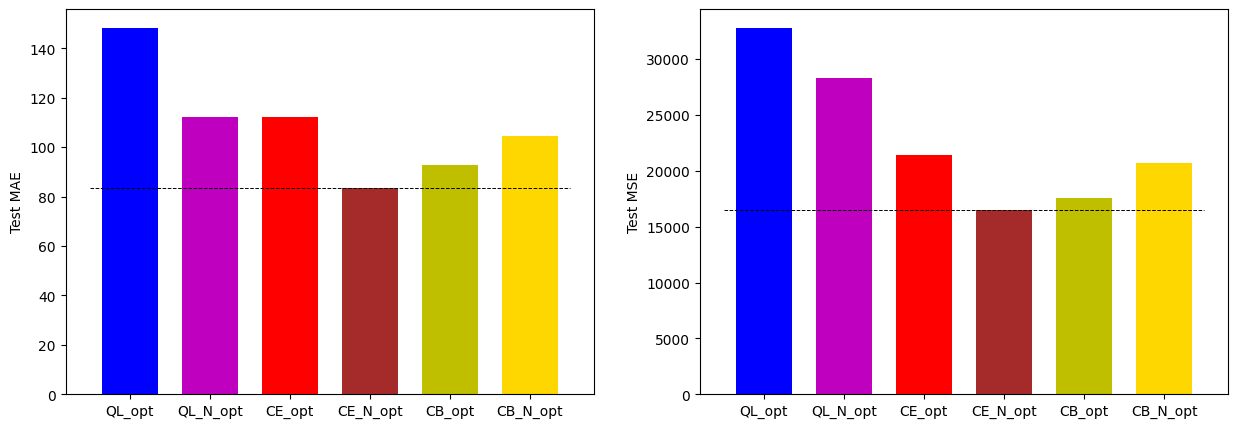

In [13]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

x_axis  = np.arange(-0.5,6.5)

ax[0].plot(x_axis, [np.min(list_test_mae)] * len(x_axis), "--k", linewidth=0.7)
ax[0].bar(list_method_used, list_test_mae, color=color_list, width = 0.7)
ax[0].set_ylabel("Test MAE")

ax[1].plot(x_axis, [np.min(list_test_mse)] * len(x_axis), "--k", linewidth=0.7)
ax[1].bar(list_method_used, list_test_mse, color=color_list, width = 0.7)
ax[1].set_ylabel("Test MSE")